In [22]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [23]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

# Goal

Calculate ci metrics for each release and output a dataset with one entry for release and a list of metrics as features

In [24]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.Date = pd.to_datetime(tags.Date)
tags.head(2)

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7


### Import builds and jobs

In [25]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)
builds.head(2)

,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,6995,NaN,99118995,push,2015-12-28 16:34:08+00:00,NaN,2015-12-28 16:18:41+00:00,5361.0,failed,28.0,12.0,2015.0
1,6994,NaN,99100662,push,2015-12-28 14:36:03+00:00,NaN,2015-12-28 14:18:30+00:00,5953.0,passed,28.0,12.0,2015.0


In [26]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs.shape

(136983, 13)

### Import tag comparison pairs

In [27]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison = tags_comparison[3:]
tags_comparison[["from_tag", "to_tag"]]

,from_tag,to_tag
3,5.1.2,5.2
4,5.2,5.3
5,5.3,5.4
6,5.4,5.5
7,5.5,5.6
8,5.6,5.6.1
9,5.6.1,5.6.2
10,5.6.1,6.0
11,5.6.2,5.6.3
12,5.6.3,5.6.4


## Import release commits

In [28]:
def replace_tags_with_jira(df):
    df = df.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
    .drop(columns=["to_tag", "Tag"]).rename(columns={"jira_version":"to_tag"})
    df = df.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
    .drop(columns=["from_tag", "Tag"]).rename(columns={"jira_version":"from_tag"})
    return df

### Load jobs for releases

In [29]:
jobs_from_direct = pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_from_direct.csv", index_col=0)

In [30]:
jobs_from_direct_prs = pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_from_direct_prs.csv", index_col=0)

In [31]:
jobs_head_ref_before_pr = pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_head_ref_before_pr.csv", index_col=0)

In [32]:
jobs_iterative_approach = pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_iterative_approach.csv", index_col=0)

In [33]:
jobs_iterative_cherry_rebase =  pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_iterative_cherry_rebase.csv", index_col=0)

### Uniform types

In [34]:
for df in [jobs_from_direct, jobs_from_direct_prs, jobs_head_ref_before_pr,\
          jobs_iterative_approach, jobs_iterative_cherry_rebase, tags_comparison]:
    df.to_tag = df.to_tag.astype(str)
    df.from_tag = df.from_tag.astype(str)

### Method 1

In [35]:
method1 = jobs_from_direct_prs.append(jobs_from_direct)
method1 = method1.drop_duplicates(ignore_index=True)

In [36]:
method1.shape

(61586, 3)

<AxesSubplot:xlabel='to_tag'>

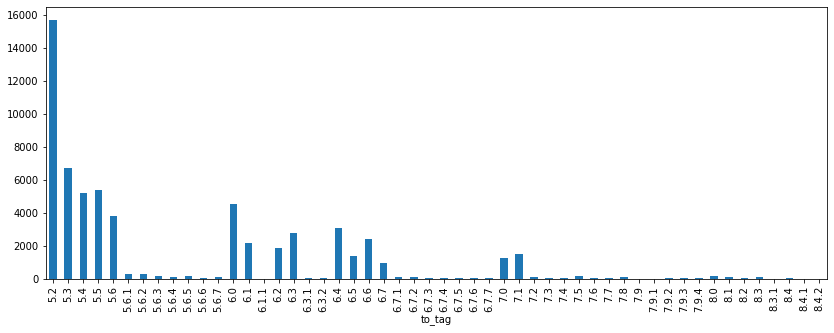

In [37]:
method1.groupby("to_tag").job_id.count().plot(kind="bar")

### Method 2

In [38]:
method2 = jobs_iterative_cherry_rebase
method2.shape

(210342, 3)

<AxesSubplot:xlabel='to_tag'>

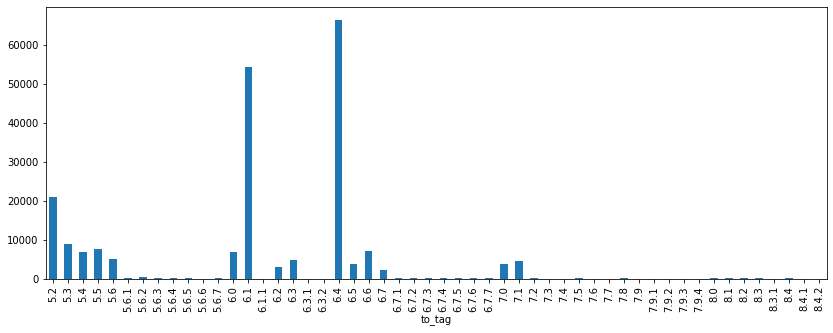

In [39]:
method2.groupby("to_tag").job_id.count().plot(kind="bar")

<AxesSubplot:xlabel='to_tag'>

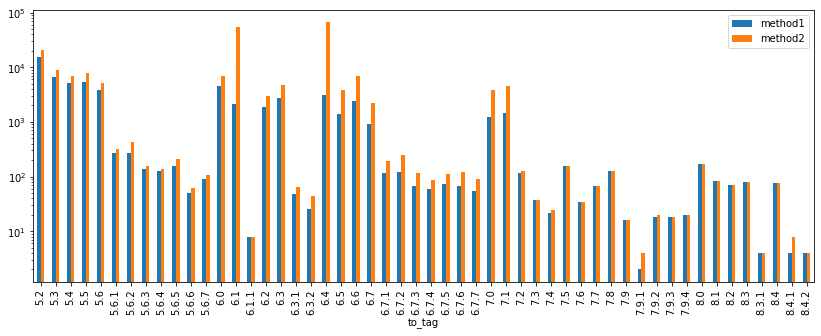

In [40]:
df_methods = method2.groupby("to_tag").job_id.count().reset_index()
df_methods["method1"] = method1.groupby("to_tag").job_id.count().values
df_methods["method2"] = method2.groupby("to_tag").job_id.count().values
df_methods.set_index("to_tag")[["method1", "method2"]].plot(kind="bar", logy=True)

# Start

In [41]:
def get_builds_from_commits(_commits):
    _build_ids = jobs[jobs.commitsha.isin(_commits)].buildid
    return builds[(builds.id.isin(_build_ids))]

def get_builds_from_jobs_ids(_release_jobs_ids):
    _build_ids = jobs[jobs.id.isin(_release_jobs_ids)].buildid
    return builds[(builds.id.isin(_build_ids))]

def get_builds_from_ids(_builds, _build_ids):
    return _builds[(_builds.id.isin(_build_ids))]

def get_job_ids_from_comparison_row(row, _jobs):
    _x = _jobs
    return _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id

def get_commits_from_comparison_row(row, commitsDf):
    _x = commitsDf
    return _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha

### Prepare 2 dataframes for the 2 commits methodologies

In [42]:
tc_direct_prs = tags_comparison.copy()
tc_iterative_cherry_rebase = tags_comparison.copy()

In [43]:
df_jobs = [(tc_direct_prs, method1, "direct_and_pr"),
(tc_iterative_cherry_rebase, method2, "iterative_pr_head_ref_cherry_picked")]

**Test**

In [45]:
_x =jobs_iterative_approach
_x[(_x.from_tag == "7.9.1") & (_x.to_tag == "7.9.2")].job_id

209781    599155930
209782    599155931
209783    599572842
209784    599572843
209785    602471512
209786    602471513
209787    617883798
209788    617883799
209789    618731614
209790    618731615
209791    619791523
209792    619791524
209793    620294154
209794    620294155
209795    621283239
209796    621283240
209797    671604177
209798    671604178
Name: job_id, dtype: int64

### Builds metrics

**Percentage of builds per state**

In [46]:
def calculate_percentage_state_builds(row, release_jobs, state):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _all_builds = get_builds_from_jobs_ids(_jobs_ids)
    _builds = _all_builds[(_all_builds.state.isin(state))]
    if(len(_all_builds)==0):
        return 0
    return len(_builds)/len(_all_builds)

In [47]:
for state in ["passed", "canceled", "failed", "errored"]:
    for df, release_jobs, method in df_jobs:
        df[f"ratio_{state}_builds"] = \
        df.apply(calculate_percentage_state_builds, args=(release_jobs, [state]), axis=1)

<Figure size 1008x360 with 0 Axes>

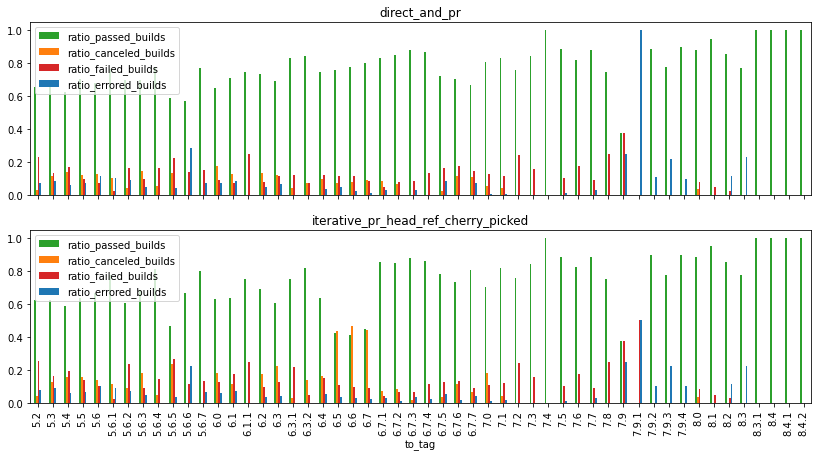

In [50]:
plt.figure()
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    cols = []
    for state in ["passed", "canceled", "failed", "errored"]:
        cols.append(f"ratio_{state}_builds")
    ax = df_job[0].set_index("to_tag").sort_index()[cols].plot(ax=axes[i], kind="bar", color=["tab:green","tab:orange", "tab:red", "tab:blue"])
    ax.set_title(df_job[2])
plt.savefig(f"{figure_folder}/ci-metrics/percentage_state_builds.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Number of builds per pull request**

In [51]:
def calculate_percentage_pr_builds(row, release_jobs):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _all_builds = get_builds_from_jobs_ids(_jobs_ids)
    _builds = _all_builds[(_all_builds.event_type == "pull_request")]
    return len(_builds)/len(_all_builds)

In [52]:
for df, release_jobs, method in df_jobs:
    df[f"ratio_pr_builds"] = \
    df.apply(calculate_percentage_pr_builds, args=(release_jobs,), axis=1)

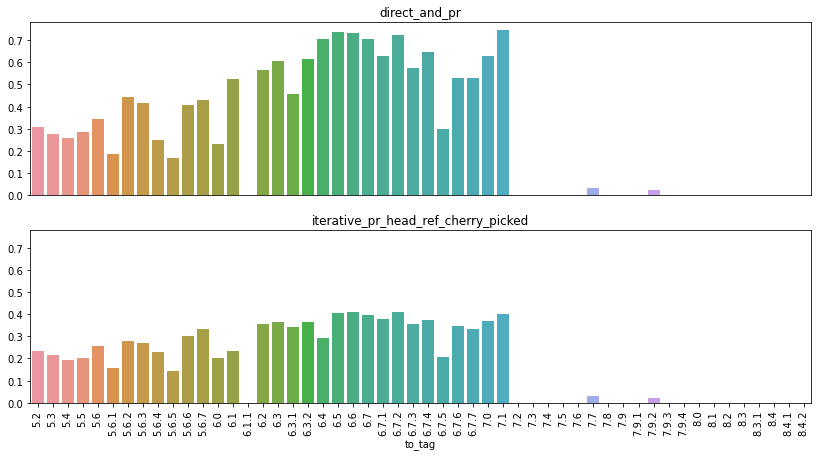

In [53]:
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, sharey=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    ax = sns.barplot(x=df_job[0].set_index("to_tag").sort_index()["ratio_pr_builds"].index, \
                y=df_job[0]["ratio_pr_builds"].values, ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(df_job[2])
    if(i < len(df_jobs) - 1):
        ax.get_xaxis().set_visible(False)

* 0% pull request builds may indicate mostly bug fixing done directly on the version branch. 
Indeed all the pairs with 0% do not represent major version upgrades

**Build duration for passed builds**

In [54]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_aggregator_build_duration(row, release_jobs, aggregator, state=None):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _all_builds = get_builds_from_jobs_ids(_jobs_ids)
    if(not state):
        _series = _all_builds.duration
    else:
        _series = _all_builds[_all_builds.state.isin(state)].duration
    res = getattr(_series, aggregator)()
    return res

In [55]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_all_build_duration"] = \
        df.apply(calculate_aggregator_build_duration, args=(release_jobs,agg), axis=1)
        
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_failed_build_duration"] = \
        df.apply(calculate_aggregator_build_duration, args=(release_jobs,agg, ["failed"]), axis=1)

for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_passed_build_duration"] = \
        df.apply(calculate_aggregator_build_duration, args=(release_jobs,agg, ["passed"]), axis=1)

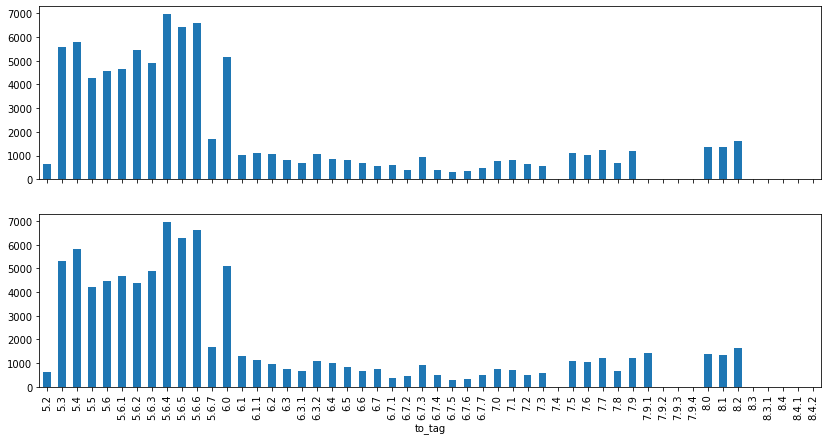

In [58]:
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, sharey=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    df_job[0].set_index("to_tag").sort_index().\
        median_failed_build_duration.plot(kind="bar", ax=axes[i], color=["tab:blue"])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(df_job[2])
    if(i < len(df_jobs) - 1):
        ax.get_xaxis().set_visible(False)

**Number of builds per pull request**

In [59]:
### Mean or median of number of jobs per pull request
def calculate_aggregator_n_builds_per_pull_request(row, release_jobs, aggregator):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _jobs = jobs[jobs.id.isin(_jobs_ids)]
    _series = _jobs.groupby("commitref").buildid.nunique()
    res = getattr(_series, aggregator)()
    return res if not np.isnan(res) else 0

In [60]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_n_builds_per_pull_request"] = \
        df.apply(calculate_aggregator_n_builds_per_pull_request, args=(release_jobs,agg), axis=1)

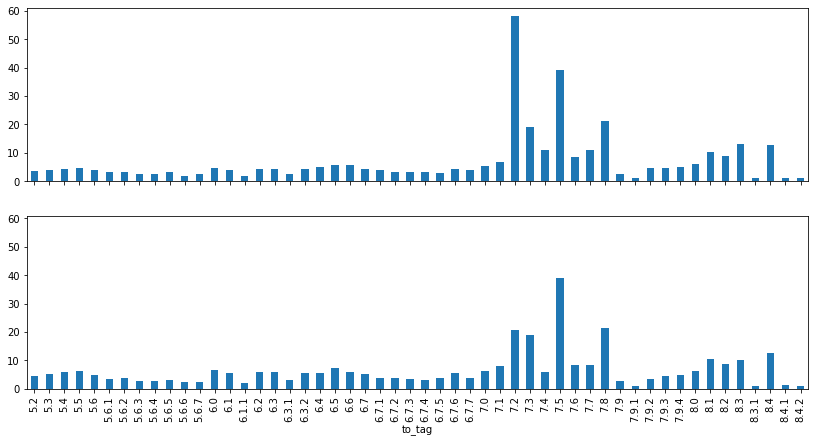

In [62]:
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, sharey=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    df_job[0].set_index("to_tag").sort_index().\
        mean_n_builds_per_pull_request.plot(kind="bar", ax=axes[i], color=["tab:blue"])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(df_job[2])
    if(i < len(df_jobs) - 1):
        ax.get_xaxis().set_visible(False)

<ipython-input-63-cd09b00dd578>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[method] = df[columns]
<ipython-input-63-cd09b00dd578>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[method] = df[columns]
<ipython-input-63-cd09b00dd578>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

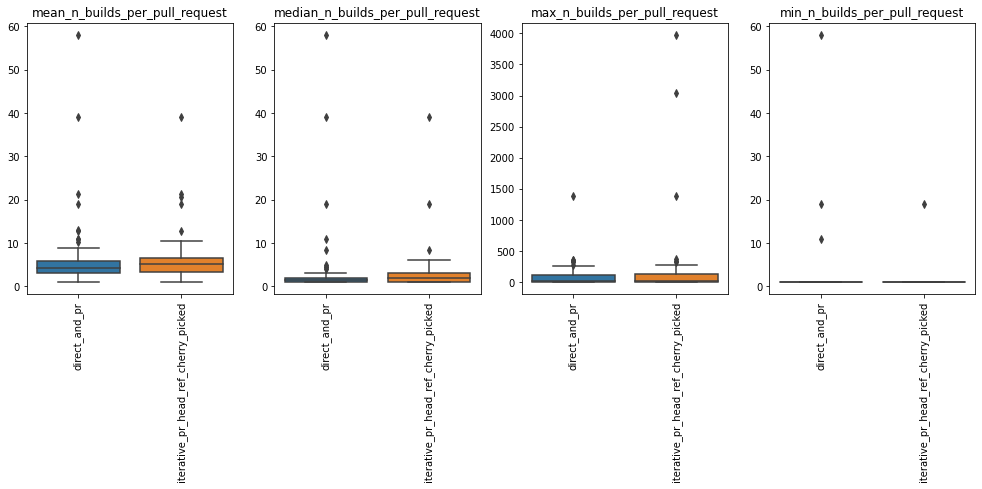

In [63]:
aggregators = ["mean", "median", "max", "min"]
fig, axes = plt.subplots(nrows=1, ncols=len(aggregators), sharex=True, figsize=(17.0, 5.0))
for i, agg in enumerate(aggregators):
    tmp_df = tags_comparison[["to_tag"]]
    columns = f"{agg}_n_builds_per_pull_request"
    for df, release_jobs, method in df_jobs:
        tmp_df[method] = df[columns]
    ax = sns.boxplot(data=tmp_df, ax=axes[i])
    ax.set_title(columns)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

**Number of builds per commitmessage**

### number of builds per pull request
def calculate_aggregator_n_builds_per_commitmessage(row, commitsDf, aggregator):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    _series = _jobs.groupby("commitmessage").buildid.nunique()
    res = getattr(_series, aggregator)()
    return res if not np.isnan(res) else 0
    
def calculate_aggregator_n_builds_per_commitmessage_per_commit_pr(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_iterative_pr_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_direct(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_comparison_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_fix(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_fix_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_pr_and_fix(row, aggregator):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_aggregator_n_builds_per_commitmessage(row, _tmp, aggregator)

for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_n_builds_per_commitmessage"] =\
    tags_comparison.apply(calculate_aggregator_n_builds_per_commitmessage_per_commit_pr_and_fix,\
                          args=(agg,), axis=1)

tags_comparison.max_n_builds_per_commitmessage.plot(kind="bar")

tags_comparison[["mean_n_builds_per_commitmessage", "median_n_builds_per_commitmessage"]].plot(kind="bar")

### Jobs metrics

**Average job duration**

jobs["duration"] = (jobs.finished_at - jobs.started_at) / np.timedelta64(1, "s")

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_job_duration(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    return _jobs.duration.mean()

def calculate_average_job_duration_pr(row):
    return calculate_average_job_duration(row, tags_iterative_pr_commits)
def calculate_average_job_duration_direct(row):
    return calculate_average_job_duration(row, tags_comparison_commits)
def calculate_average_job_duration_fix(row):
    return calculate_average_job_duration(row, tags_fix_commits)

tags_comparison["mean_job_duration_builds_passed_or_failed"] = tags_comparison.apply(calculate_average_job_duration_pr, axis=1)

**Average failed jobs per commit**

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_failed_job_per_commit(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    _jobs = _jobs[_jobs.state == "failed"]
    return _jobs.groupby("commitsha").state.count().mean()

def calculate_average_failed_job_per_commit_pr(row):
    return calculate_average_failed_job_per_commit(row, tags_iterative_pr_commits)
def calculate_average_failed_job_per_commit_direct(row):
    return calculate_average_failed_job_per_commit(row, tags_comparison_commits)
def calculate_average_failed_job_per_commit_fix(row):
    return calculate_average_failed_job_per_commit(row, tags_fix_commits)
def calculate_average_failed_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_failed_job_per_commit(row, _tmp)

tags_comparison["average_failed_job_per_commit"] = tags_comparison.apply(calculate_average_failed_job_per_commit_pr, axis=1)

sns.barplot(x=tags_comparison["average_failed_job_per_commit"].index, \
            y=tags_comparison["average_failed_job_per_commit"].values)

**Number of jobs canceled or errored**

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_canceled_or_errored_job(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return len(_jobs[_jobs.state.isin(["canceled", "errored"])]) / len(_jobs)

def calculate_percentage_canceled_or_errored_job_per_commit_pr(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_iterative_pr_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_direct(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_comparison_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_fix(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_fix_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_canceled_or_errored_job(row, _tmp)

tags_comparison["percentage_canceled_or_errored_job"] =\
tags_comparison.apply(calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix, axis=1)

sns.barplot(x=tags_comparison["percentage_canceled_or_errored_job"].index, \
            y=tags_comparison["percentage_canceled_or_errored_job"].values)

**Is commitsha and commitref identical for all jobs associated with the same buildid?**

(jobs.groupby("buildid").commitsha.nunique() > 1).sum()

(jobs.groupby("buildid").commitref.nunique() > 1).sum()

Yes, therefore we can add this info to the build df

### Log parsing metrics

In [64]:
log_parsed_metrics = pd.read_csv(f"{csv_folder}/log_parsed_metrics_processed.csv", index_col=0)

In [65]:
log_parsed_metrics.head(3)

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,year_month,errors_over_tests_total,failures_over_tests_total,skipped_over_tests_total
0,346751001,WEB_TESTS,['yarn'],False,3.0,2.0,1.0,2.0,1.0,1045.0,3294.0,[],[],1120.0,1117.0,0.0,3.0,[],['yarn'],0,0,1,False,False,False,False,False,True,False,346751001,346750998,2018-02-27 12:30:57+00:00,2018-02-27 12:30:21.579000+00:00,2018-02-27 12:34:24+00:00,37569.2,passed,2018-06-04 05:43:54.693000+00:00,7b245fbc45898ce11ab5cc0d60dc4f5621b94645,103144209,SONAR-10047 Use SearchSelect for tags in Bulk ...,refs/pull/3103/merge,https://github.com/SonarSource/sonarqube/pull/...,2018/02,0.002676,0.001784,0.000892
1,575471642,WEB_TESTS,"['yarn', 'jest', 'gradle']",False,3.0,2.0,1.0,9.0,1.0,1362.0,3919.0,[],[],2006.0,2005.0,0.0,1.0,[],"['yarn', 'jest', 'gradle']",0,0,3,False,True,False,True,False,True,False,575471642,575471639,2019-08-22 18:21:52+00:00,2019-08-22 18:21:19.464000+00:00,2019-08-22 18:33:18+00:00,39085.2,passed,2019-08-22 18:33:18.698000+00:00,7c2a234b30826c8f98dabff8506b1f49884b83a5,174121400,DOCS Add instructions for Application to a Por...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2019/08,0.001495,0.000997,0.000498
2,721125402,WEB_TESTS,"['yarn', 'gradle']",False,14.0,3.0,3.0,30.0,0.0,1426.0,4196.0,[],[],2412.0,2412.0,0.0,0.0,[],"['yarn', 'gradle']",0,0,2,False,True,False,False,False,True,False,721125402,721125400,2020-08-25 20:08:05+00:00,2020-08-25 20:06:58.581000+00:00,2020-08-25 20:18:58+00:00,39397.2,passed,2020-08-25 20:18:58.561000+00:00,60c64b2c9f95bb52d070758fa88a3881ae69b5e7,222268239,SONAR-13766 PostProjectAnalysisTask's 'descrip...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2020/08,0.005802,0.001243,0.000000


In [66]:
log_parsed_metrics.columns

Index(['job_id', 'build_target', 'build_tool',
       'build_canceled_open_pr_on_branch', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped', 'failed_tasks', 'build_tool_str',
       'n_exceptions', 'n_error_classes', 'n_build_tools', 'maven_build',
       'gradle_build', 'mocha_build', 'jest_build', 'grunt_build',
       'yarn_build', 'node_build', 'id', 'buildid', 'started_at', 'created_at',
       'finished_at', 'number', 'state', 'updated_at', 'commitsha', 'commitid',
       'commitmessage', 'commitref', 'commitcompare_url', 'year_month',
       'errors_over_tests_total', 'failures_over_tests_total',
       'skipped_over_tests_total'],
      dtype='object')

In [67]:
def calculate_aggregator_for_column(row, release_jobs, column, aggregator):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _jobs = jobs[jobs.id.isin(_jobs_ids)]
    _series = log_parsed_metrics[log_parsed_metrics.job_id.isin(_jobs.id.unique())][column]
    return getattr(_series, aggregator)()

**Errors over tests**

In [68]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_errors_over_tests_total"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"errors_over_tests_total", agg), axis=1)

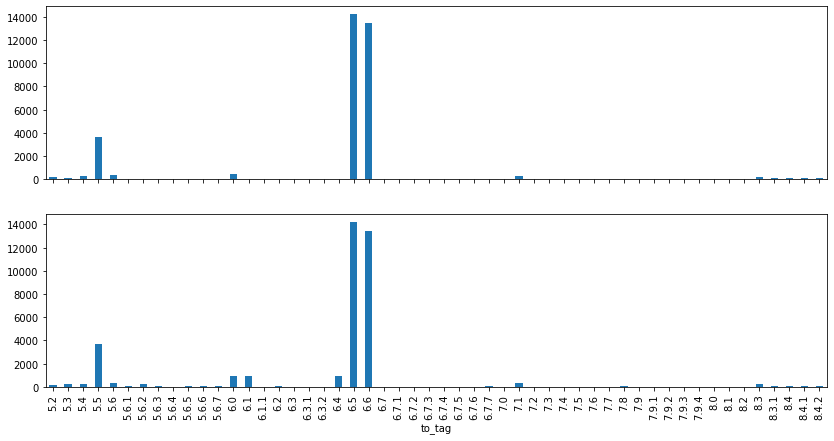

In [70]:
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, sharey=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    df_job[0].set_index("to_tag").sort_index().\
        max_errors_over_tests_total.plot(kind="bar", ax=axes[i], color=["tab:blue"])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(df_job[2])
    if(i < len(df_jobs) - 1):
        ax.get_xaxis().set_visible(False)

**Failed tests**

In [71]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_failed_tests"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"tests_failed", agg), axis=1)

**Failures over total tests**

In [72]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_failures_over_tests_total"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"failures_over_tests_total", agg), axis=1)

**Skipped over tests**

In [73]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_skipped_over_tests_total"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"skipped_over_tests_total", agg), axis=1)

**Number of exceptions**

In [74]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_n_exceptions"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"n_exceptions", agg), axis=1)

**Number of warnings**

In [75]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_n_warnings"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"warnings", agg), axis=1)

**Number of error classes**


In [76]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_n_error_classes"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"n_error_classes", agg), axis=1)

### Build burst metrics

In [77]:
builds_commitref = jobs.drop_duplicates(subset=["buildid", "commitref", "commitsha"], keep="first")[["buildid", "commitref", "commitsha"]]\
.merge(builds, left_on="buildid", right_on="id")
builds_commitref.head(40)

,buildid,commitref,commitsha,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,241946099,refs/heads/feature/atlas/MMF-324/builtin-profiles,2e4b539138fde6f664a865c81fb6ab0763f74bdb,25614,NaN,241946099,push,2017-06-12 09:21:43+00:00,NaN,2017-06-12 09:21:03+00:00,40.0,canceled,12.0,6.0,2017.0
1,241952022,refs/heads/feature/atlas/MMF-324/builtin-profiles,464f5da96733c14818f4b4bfeb878951b859ee0c,25615,NaN,241952022,push,2017-06-12 09:37:24+00:00,NaN,2017-06-12 09:36:43+00:00,40.0,canceled,12.0,6.0,2017.0
2,241952044,refs/pull/2104/merge,7358e9a93e47ac9fcaebe960c00ab8bd28e9890e,25616,2104.0,241952044,pull_request,2017-06-12 09:53:48+00:00,MMF-324 introduce concept of build-in Quality ...,2017-06-12 09:42:15+00:00,973.0,passed,12.0,6.0,2017.0
3,241955852,refs/heads/feature/jl/onboarding,00e86fd06991a1e54e3b17eb82f2532f85de6489,25617,NaN,241955852,push,2017-06-12 09:56:41+00:00,NaN,2017-06-12 09:50:40+00:00,610.0,failed,12.0,6.0,2017.0
4,241956721,refs/heads/feature/stas/onboarding/tutorial,b34d8845506f0de01138e525d118fe292d204334,25618,NaN,241956721,push,2017-06-12 09:51:07+00:00,NaN,2017-06-12 09:50:27+00:00,64.0,canceled,12.0,6.0,2017.0
5,241956741,refs/pull/2137/merge,0110c87fd42c510bb2c2f7a274d654a9fb07fb29,25619,2137.0,241956741,pull_request,2017-06-12 10:01:41+00:00,UI: SONAR-9355 Create onboarding tutorial,2017-06-12 09:50:05+00:00,1047.0,passed,12.0,6.0,2017.0
6,241963248,refs/heads/feature/jl/onboarding,8823b927339cbb7110f02c42bd12a04ea658897d,25620,NaN,241963248,push,2017-06-12 10:19:03+00:00,NaN,2017-06-12 10:08:56+00:00,885.0,passed,12.0,6.0,2017.0
7,241974640,refs/heads/feature/lambda/onboarding,fc4e2b219f729fd10dba979629ca79eeff0d726c,25621,NaN,241974640,push,2017-06-12 10:52:06+00:00,NaN,2017-06-12 10:51:28+00:00,75.0,canceled,12.0,6.0,2017.0
8,241974654,refs/pull/2133/merge,baf18566bc2af9cab1c72b851ce9e08d3714c731,25622,2133.0,241974654,pull_request,2017-06-12 11:07:10+00:00,MMF-886 Better first-time developer experience,2017-06-12 10:51:36+00:00,1360.0,passed,12.0,6.0,2017.0
9,241975118,refs/pull/2161/merge,939b617446ccc889408ea39ecf00e396443dcedb,25623,2161.0,241975118,pull_request,2017-06-12 11:10:44+00:00,SONAR-9356 Show onboarding tutorial only once ...,2017-06-12 10:54:03+00:00,1463.0,passed,12.0,6.0,2017.0


In [78]:
def detect_build_bursts(_builds, gap_size, burst_size, states):
    positive_count = 0
    negative_count = 0
    n_bursts = 0
    burst_sizes = []
    i = 0
    for index, row in _builds.sort_values(by="started_at").iterrows():
        i+=1
        if((i == len(_builds)) | (not (row.state in states))):
            negative_count+=1
            if(negative_count == gap_size):
                if(positive_count >= burst_size):
                    n_bursts+=1
                    burst_sizes.append(positive_count)
                negative_count = 0
                positive_count = 0
        if(row.state in states):
            positive_count+=1
    return n_bursts, burst_sizes

def build_burst_metrics(row, _release_jobs, states):
    _job_ids = get_job_ids_from_comparison_row(row, _release_jobs)
    _builds = get_builds_from_jobs_ids(_job_ids)
    _builds = builds_commitref[builds_commitref.id.isin(_builds.id)]
    res = {}
    for gap_size in [1,2,3]:
        for burst_size in [1,2,3]:
            commitref_data=[]
            for commitref in _builds.commitref.unique():
                _ref_builds = _builds[_builds.commitref==commitref]
                commitref_data.append(detect_build_bursts(_ref_builds, gap_size, burst_size, states))
            bursts = np.array([])
            bursts_sizes = np.array([])
            for d in commitref_data:
                bursts = np.append(bursts,d[0])
                for v in d[1]:
                    bursts_sizes = np.append(bursts_sizes,v)
            if not gap_size in res:
                res[gap_size] = {}
            res[gap_size][burst_size] = (bursts, bursts_sizes)
    return res

def get_failed_burst_metrics(row, _release_jobs):
    return build_burst_metrics(row, _release_jobs, ["failed"])

def get_canceled_burst_metrics(row, _release_jobs):
    return build_burst_metrics(row, _release_jobs, ["canceled"])

def get_not_passed_burst_metrics(row, _release_jobs):
    return build_burst_metrics(row, _release_jobs, ["failed", "canceled", "errored"])

In [79]:
def burst_metrics_analysis(burst_metrics, type_str):
    cols = ["index"]
    data = []
    for i, row in burst_metrics.items():
        inner_data = [i]
        for gap in row:
            for burst_size in row[gap]:
                bursts = row[gap][burst_size][0]
                burst_sizes = row[gap][burst_size][1]
                inner_data.append(bursts.mean())
                inner_data.append(np.median(bursts))
                inner_data.append(bursts.max())
                inner_data.append(bursts.min())
                if(i == 3):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_n_bursts_{metric}")
                inner_data.append(burst_sizes.mean())
                inner_data.append(np.median(burst_sizes))
                inner_data.append(np.max(burst_sizes, initial=0))
                inner_data.append(np.min(burst_sizes, initial=0))
                if(i == 3):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_burst_size_{metric}")
        data.append(tuple(inner_data))
    return data, cols

**Not passed burst metrics**

not_passed_burst_metrics = {}
for df, release_jobs, method in df_jobs:
    metrics = df.apply(get_not_passed_burst_metrics,args=(release_jobs,),axis=1)
    not_passed_burst_metrics[method]=metrics

df_jobs_bursts = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs):
    data, cols = burst_metrics_analysis(not_passed_burst_metrics[method], "not_passed")
    not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
    not_passed_burst_metrics_df.set_index("index", inplace=True)
    not_passed_burst_metrics_df.fillna(0, inplace=True)
    df_jobs_bursts[i] = (df.join(not_passed_burst_metrics_df), release_jobs, method)

#checkpoint of calculation up until here
for df_burst, release_jobs, method in df_jobs_bursts: 
    df_burst.to_csv(f"{csv_folder}/ci_metrics/{method}_not_passed_burst_metrics.csv")

#retrieve checkpoint of calculation up until here
df_jobs_bursts = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs): 
    tmp = pd.read_csv(f"{csv_folder}/ci_metrics/{method}_not_passed_burst_metrics.csv", index_col=0)
    df_jobs_bursts[i] = (tmp, release_jobs, method)

**Canceled burst metrics**

cenceled_burst_metrics = {}
for df, release_jobs, method in df_jobs_bursts:
    metrics = df.apply(get_canceled_burst_metrics,args=(release_jobs,),axis=1)
    cenceled_burst_metrics[method]=metrics

for i, (df, release_jobs, method) in enumerate(df_jobs_bursts):
    data, cols = burst_metrics_analysis(not_passed_burst_metrics[method], "canceled")
    not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
    not_passed_burst_metrics_df.set_index("index", inplace=True)
    not_passed_burst_metrics_df.fillna(0, inplace=True)
    df_jobs_bursts[i] = (df.join(not_passed_burst_metrics_df), release_jobs, method)

#checkpoint of calculation up until here
for df_burst, release_jobs, method in df_jobs_bursts: 
    df_burst.to_csv(f"{csv_folder}/ci_metrics/{method}_not_passed_+_canceled_burst_metrics.csv")

#retrieve checkpoint of calculation up until here
df_jobs_bursts = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs): 
    tmp = pd.read_csv(f"{csv_folder}/ci_metrics/{method}_not_passed_+_canceled_burst_metrics.csv", index_col=0)
    df_jobs_bursts[i] = (tmp, release_jobs, method)

**Failed burst metrics**

failed_burst_metrics = {}
for df, release_jobs, method in df_jobs_bursts:
    metrics = df.apply(get_failed_burst_metrics,args=(release_jobs,),axis=1)
    cenceled_burst_metrics[method]=metrics

for i, (df, release_jobs, method) in enumerate(df_jobs_bursts):
    data, cols = burst_metrics_analysis(not_passed_burst_metrics[method], "failed")
    not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
    not_passed_burst_metrics_df.set_index("index", inplace=True)
    not_passed_burst_metrics_df.fillna(0, inplace=True)
    df_jobs_bursts[i] = (df.join(not_passed_burst_metrics_df), release_jobs, method)

#checkpoint of calculation up until here
for df_burst, release_jobs, method in df_jobs_bursts: 
    df_burst.to_csv(f"{csv_folder}/ci_metrics/{method}_all_burst_metrics.csv")

In [96]:
#retrieve checkpoint of calculation up until here
df_jobs_bursts = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs): 
    tmp = pd.read_csv(f"{csv_folder}/ci_metrics/{method}_all_burst_metrics.csv", index_col=0)
    df_jobs_bursts[i] = (tmp, release_jobs, method)

**Software quality metrics**

In [97]:
sw_quality_metrics= pd.read_csv(f"{csv_folder}/tags_software_quality_metrics_no_rc_and_milestones.csv", index_col=0)
sw_quality_metrics.head(2)

,version_name,post_release_bugs,pre_release_bugs,dde,critical_post_release_bugs,minor_post_release_bugs,fix_time
0,4.5.7,1.0,0.0,0.000000,0.0,0.0,-434.28603
1,5.1,17.0,7.0,0.291667,0.0,1.0,-76.54260


In [98]:
sw_quality_metrics.columns

Index(['version_name', 'post_release_bugs', 'pre_release_bugs', 'dde',
       'critical_post_release_bugs', 'minor_post_release_bugs', 'fix_time'],
      dtype='object')

**Merging**

In [99]:
for i, (df, release_jobs, method) in enumerate(df_jobs_bursts):
    print(df.shape)

(52, 280)
(52, 280)


In [100]:
sw_quality_metrics

,version_name,post_release_bugs,pre_release_bugs,dde,critical_post_release_bugs,minor_post_release_bugs,fix_time
0,4.5.7,1.0,0.0,0.000000,0.0,0.0,-434.286030
1,5.1,17.0,7.0,0.291667,0.0,1.0,-76.542600
2,5.1.1,6.0,0.0,0.000000,0.0,0.0,-18.665239
3,5.1.2,3.0,0.0,0.000000,0.0,0.0,-103.197836
4,5.2,36.0,2.0,0.052632,0.0,3.0,-63.796018
5,5.3,12.0,3.0,0.200000,1.0,1.0,-68.484954
6,5.4,15.0,11.0,0.423077,1.0,0.0,-61.146803
7,5.5,6.0,2.0,0.250000,0.0,1.0,-16.349603
8,5.6,34.0,1.0,0.028571,0.0,2.0,-54.132595
9,5.6.1,9.0,0.0,0.000000,0.0,1.0,-92.887575


In [101]:
set(df_jobs_bursts[0][0].to_tag).difference(sw_quality_metrics.version_name.values)

set()

In [102]:
set(sw_quality_metrics.version_name.values).difference(set(df_jobs_bursts[0][0].to_tag))

{'4.5.7', '5.1', '5.1.1', '5.1.2', '6.5-M1'}

In [105]:
df_jobs_sw_metrics = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs_bursts):
    dataset_with_sw_metrics = df.merge(sw_quality_metrics, left_on="to_tag", right_on="version_name")
    df_jobs_sw_metrics[i] = (dataset_with_sw_metrics, release_jobs, method)
    dataset_with_sw_metrics.to_csv(f"{csv_folder}/final_datasets/{method}_with_sw_metrics.csv")